# NYC Rideshare Forecasting Pipeline - Part 4: Demand Forecasting

**Author:** Kristi Flowers  
**GitHub:** [github.com/KRFlowers](https://github.com/KRFlowers)  
**Date:** December 2025

This notebook builds forecasting models to predict daily NYC rideshare demand. The dataset contains 684M High Volume FHV (Uber/Lyft) trip records from 2022-2024, aggregated to daily zone-level totals. Forecasting is limited to 1-day-ahead predictions as a proof of concept.

**Scope:**
- Three models evaluated: Seasonal Naive (baseline), Prophet, XGBoost
- Analysis limited to top 100 zones (72% of total citywide demand)
- EDA revealed weekly and seasonal patterns with high zone correlation

**Pipeline Position:** Notebook 3 of 4 — Demand Forecasting

- 00_data_download.ipynb
- 01_data_validation.ipynb
- 02_exploratory_analysis.ipynb
- 03_demand_forecasting.ipynb ← **this notebook**

**Objective:** Develop a forecasting model that predicts daily zone-level demand, targeting <10% MAPE for operational planning.

**Technical Approach:**
- Compare three models: Seasonal Naive (baseline), Prophet, XGBoost
- Split data temporally for time series: Jan 2022–Jun 2024 train, Jul–Dec 2024 test
- Engineer lag-based features (7-day) aligned with weekly patterns found during EDA

**Inputs:**
- `data/processed/zone_daily.parquet` — Zone-level daily aggregates
- `data/raw/zone_metadata.csv` — Zone reference information

**Outputs:**
- `data/results/forecast_results.csv` — Daily forecasts with error metrics
- `data/results/summary_results.csv` — Zone-level performance summary

**Runtime:** ~15 minutes

## Model Selection Rationale

Three forecasting approaches were selected based on EDA findings and forecasting best practices: Seasonal Naive, Prophet, and XGBoost. Given the stable, predictable patterns found in the data, these methods should be sufficient, though this will be evaluated based on model performance. Also, STL decomposition was not applied during preprocessing since EDA showed only moderate seasonality. If model residuals show possibility of unaddressed seasonal patterns, this can be revisited.

**Seasonal Naive (Baseline):** A simple persistence model using same-day-last-week values. This provides a minimum performance threshold for comparison against more complex models (Hyndman & Athanasopoulos, 2021).

**Prophet:** Facebook's time series model designed for business forecasting with strong seasonality (Taylor & Letham, 2018). Widely used in industry, though research suggests gradient boosting methods often outperform Prophet on stable, high-frequency demand data.

**XGBoost:** Gradient boosting with lag-based features. Top performers in the M5 forecasting competition predominantly used LightGBM and XGBoost, particularly when patterns are consistent and feature engineering can capture them (Makridakis et al., 2022).

**Note:** EDA revealed stable weekly patterns with low within-zone variability. To capture the weekly pattern, models will be configured with lag variables.


---

## 1. Configure Environment
Import libraries, load data, and define evaluation metrics. 

### 1.1 Import Libraries

In [5]:
# Core libraries
import pandas as pd
import numpy as np
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Configuration
import warnings
import logging
warnings.filterwarnings('ignore')
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams.update({
    'figure.figsize': (12, 4),
    'axes.titlesize': 10,
    'axes.labelsize': 9,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'legend.framealpha': 0.9,
    'grid.alpha': 0.3,
    'axes.grid': True,
    'axes.grid.axis': 'y'
})

print("Libraries imported successfully")

Libraries imported successfully


### 1.2 Set Display and Plot Options

In [ ]:
# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Visualization settings
sns.set_palette('husl')
%matplotlib inline

### 1.3 Set Paths and Constants

In [ ]:
# Paths
PROJECT_ROOT = Path("..").resolve()
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
RESULTS_DIR = PROJECT_ROOT / "data" / "results"

# Input Files
ZONE_DAILY_FILE = PROCESSED_DIR / "zone_daily.parquet"
ZONE_METADATA_FILE = PROJECT_ROOT / "data" / "raw" / "zone_metadata.csv"

# Output Files
FORECAST_RESULTS_FILE = RESULTS_DIR / "forecast_results.csv"
SUMMARY_RESULTS_FILE = RESULTS_DIR / "summary_results.csv"

# Model Parameters
TRAIN_END_DATE = '2024-06-30'
TEST_START_DATE = '2024-07-01'
TEST_END_DATE = '2024-12-31'

# Create Directory
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Config loaded: Train through {TRAIN_END_DATE}, Test {TEST_START_DATE} to {TEST_END_DATE}")

✓ Config loaded: Train through 2024-06-30, Test 2024-07-01 to 2024-12-31


### 1.4 Define Helper Functions

**Define Evaluation Metrics**: 
The purpose of this function is to define evaluation metrics that can be applied consistently across all models. 
- MAE (Mean Absolute Error) will be used as the primary metric for model selection within zones. 
- MAPE (Mean Absolute Percentage Error) will be used for cross-zone comparison and to report results
- RMSE (Root Mean Squared Error) has been included for completeness as it penalizes large errors more heavily.

In [10]:
# Create an evaluation function to ensure consistent model comparison with standard metrics across all models (MAE, RMSE, MAPE)

def evaluate_forecast(
    actual: np.ndarray, 
    predicted: np.ndarray, 
    model_name: str = "Model"
) -> dict:
    """Calculate forecast accuracy metrics.
    
    Args:
        actual: Array of actual values
        predicted: Array of predicted values  
        model_name: Name identifier for the model
        
    Returns:
        Dictionary with Model name, MAE, RMSE, and MAPE metrics
    """
    # Convert to numpy arrays to ensure positional alignment
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    
    # Exclude zero-demand days from MAPE (avoids division by zero)
    mask = actual > 0
    mape = np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100
    
    return {
        'Model': model_name,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'MAPE': round(mape, 2)
    }

print("Evaluation function defined")

Evaluation function defined


## 2. Load and Explore Data
Load zone-level aggregated data and verify data quality before modeling.

### 2.1 Load Data

In [ ]:
# Load zone-level daily aggregated data and metadata
zone_daily_df = pd.read_parquet(ZONE_DAILY_FILE)
zone_metadata_df = pd.read_csv(ZONE_METADATA_FILE)

# Ensure zone_id is integer type
zone_daily_df['zone_id'] = zone_daily_df['zone_id'].astype(int)

print(f" Data loaded:")
print(f"  zone_daily_df: {len(zone_daily_df):,} records ({zone_daily_df['zone_id'].nunique()} zones)")
print(f"  zone_metadata_df: {len(zone_metadata_df):,} records")
print(f"  Date range: {zone_daily_df['date'].min().date()} to {zone_daily_df['date'].max().date()}")

### 2.2 Review Dataset Structure

In [ ]:
# Review dataset structure and target variable distribution

print("DATASET OVERVIEW - zone_daily_df")
print("=" * 50)
print(f"Shape: {zone_daily_df.shape}")
print(f"Date range: {zone_daily_df['date'].min().date()} to {zone_daily_df['date'].max().date()}")
print(f"Zones: {zone_daily_df['zone_id'].nunique()}")

print(f"\nTARGET VARIABLE")
print("-" * 50)
print(f"Target: daily_trips (daily trip count per zone)")
print(f"Mean: {zone_daily_df['daily_trips'].mean():,.0f} trips/day")
print(f"Range: {zone_daily_df['daily_trips'].min():,} - {zone_daily_df['daily_trips'].max():,}")

print(f"\nFEATURES ({len(zone_daily_df.columns)} columns)")
print("-" * 50)
print(zone_daily_df.columns.tolist())

zone_daily_df.head()

### 2.3 Verify Data Completeness

**Note:** Complete time series data is required for lag features and seasonal patterns. Zone selection in EDA (02_exploratory_analysis.ipynb) filtered to zones and ensured continuous 36-month coverage within zones. All 100 zones in this dataset have complete daily records.

## 3. Create Train/Test Datasets

### 3.1 Create Train/Test Split

**Train/Tem Temporal Splitting:** Time series forecasting requires splitting data temporally. Historical data is used as the training set to predict future validation data.

In [ ]:
# Split data into train and test sets
train_df = zone_daily_df[zone_daily_df['date'] <= TRAIN_END_DATE].copy()
test_df = zone_daily_df[zone_daily_df['date'] >= TEST_START_DATE].copy()

print("TRAIN/TEST SPLIT")
print("=" * 40)
print(f"Train: {train_df['date'].min().date()} to {train_df['date'].max().date()} ({len(train_df):,} rows)")
print(f"Test:  {test_df['date'].min().date()} to {test_df['date'].max().date()} ({len(test_df):,} rows)")
print(f"\nTrain months: {train_df['date'].dt.to_period('M').nunique()}")
print(f"Test months: {test_df['date'].dt.to_period('M').nunique()}")

TRAIN/TEST SPLIT
Train: 2022-01-01 to 2024-06-30 (91,200 rows)
Test:  2024-07-01 to 2024-12-31 (18,400 rows)

Train months: 30
Test months: 6


In [14]:
# Validate split integrity and no data leakage
assert train_df['date'].max() < test_df['date'].min(), "Data leakage: train/test overlap"
assert len(train_df) + len(test_df) == len(zone_daily_df), "Records lost in split"
print("Split validated with no overlap, no missing records")

Split validated with no overlap, no missing records


### 3.2 Create Pilot Zone Dataset

In [ ]:
# Count zone volumes to identify highest-demand zone
zone_volumes = zone_daily_df.groupby('zone_id')['daily_trips'].mean().sort_values(ascending=False)
PILOT_ZONE_ID = int(zone_volumes.index[0])

# Filter train and test sets for the pilot zone
pilot_train_df = train_df[train_df['zone_id'] == PILOT_ZONE_ID].copy()
pilot_test_df = test_df[test_df['zone_id'] == PILOT_ZONE_ID].copy()

# Get zone name from metadata
pilot_zone_name = zone_metadata_df[zone_metadata_df['zone_id'] == PILOT_ZONE_ID]['Zone'].values[0]
print(f"PILOT ZONE: {PILOT_ZONE_ID} ({pilot_zone_name})")

print("=" * 40)
print(f"Train records: {len(pilot_train_df)}")
print(f"Test records: {len(pilot_test_df)}")
print(f"Avg daily demand: {pilot_train_df['daily_trips'].mean():,.0f} trips")

pilot_train_df.head()

---

## 4. Build Baseline Model
Builds a seasonal naive baseline using 7-day lag to preserve day-of-week alignment.


### 4.1 Build Baseline

In [24]:
# Create baseline using 7-day lag, combine train and test in order to get lag values from training period
pilot_combined = pd.concat([pilot_train_df, pilot_test_df]).sort_values('date')
pilot_combined['baseline_pred'] = pilot_combined['daily_trips'].shift(7)

# Keep only test period time fram
pilot_test_df = pilot_combined[pilot_combined['date'] >= TEST_START_DATE].copy()

print(f"Baseline predictions: {len(pilot_test_df)} days")
print(f"Missing predictions: {pilot_test_df['baseline_pred'].isna().sum()}")

Baseline predictions: 184 days
Missing predictions: 0


### 4.2 Evaluate Baseline

In [31]:
# Calculate baseline metrics

baseline_results = evaluate_forecast(
    pilot_test_df['daily_trips'], 
    pilot_test_df['baseline_pred'],
    model_name="Baseline (Seasonal Naive)"
)

# Calculate zone mean for context
zone_mean = pilot_train_df['daily_trips'].mean()

print(f"BASELINE PERFORMANCE (Zone {PILOT_ZONE_ID} - {pilot_zone_name})")
print("=" * 40)
print(f"Zone mean demand: {zone_mean:,.0f} trips/day")
print(f"MAE:  {baseline_results['MAE']:,.0f} trips/day ({baseline_results['MAE']/zone_mean*100:.1f}% of mean)")
print(f"RMSE: {baseline_results['RMSE']:,.0f} trips/day")
print(f"MAPE: {baseline_results['MAPE']:.1f}%")

BASELINE PERFORMANCE (Zone 138 - LaGuardia Airport)
Zone mean demand: 11,513 trips/day
MAE:  2,317 trips/day (20.1% of mean)
RMSE: 3,199 trips/day
MAPE: 18.8%


### 4.3 Visualize Forecast

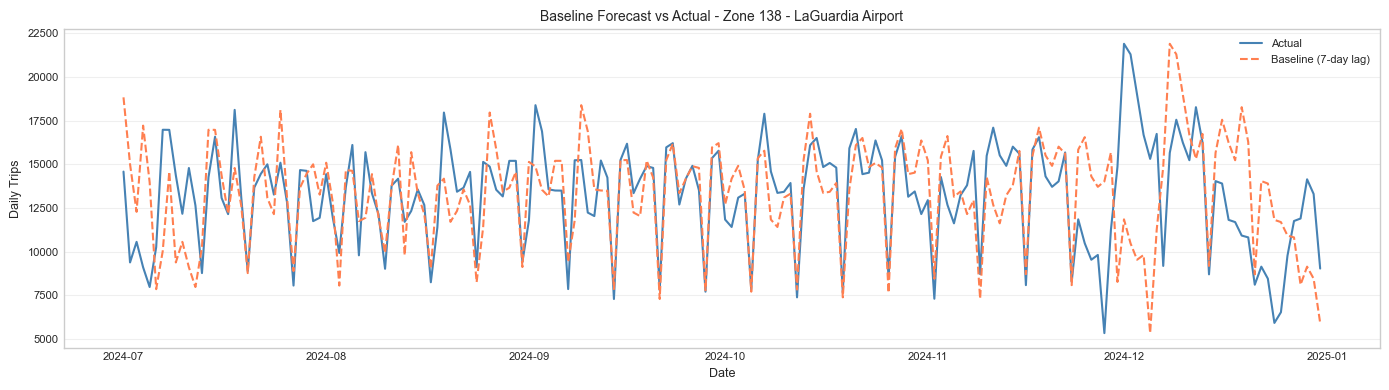

In [30]:
# What: Plot baseline forecast vs actual demand
# Why: Visual check of baseline performance

fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(pilot_test_df['date'], pilot_test_df['daily_trips'], 
        label='Actual', color='steelblue', linewidth=1.5)
ax.plot(pilot_test_df['date'], pilot_test_df['baseline_pred'], 
        label='Baseline (7-day lag)', color='coral', linewidth=1.5, linestyle='--')

ax.set_xlabel('Date')
ax.set_ylabel('Daily Trips')
ax.set_title(f'Baseline Forecast vs Actual - Zone {PILOT_ZONE_ID} - {pilot_zone_name}')
ax.legend()
plt.tight_layout()
plt.show()

**Interpretation:** The seasonal naive baseline captures weekly patterns but consistently lags behind actual demand shifts.  This can be seen during sharp transitions and the late December holiday spike. At 18.8% MAPE, this model shows moderate performance, however, there is clear room for improvement. Subsequent models that incorporate trend and holiday effects should outperform this baseline.

---

## 5. Build Prophet Model
Trains and evaluates Prophet on the pilot zone.

### 5.1 Prepare Datasets

In [32]:
# Format data for Prophet (requires 'ds' and 'y' columns)
prophet_train_df = pilot_train_df[['date', 'daily_trips']].copy()
prophet_train_df.columns = ['ds', 'y']

prophet_test_df = pilot_test_df[['date', 'daily_trips']].copy()
prophet_test_df.columns = ['ds', 'y']

print(f"Prophet train shape: {prophet_train_df.shape}")
print(f"Prophet test shape: {prophet_test_df.shape}")

Prophet train shape: (912, 2)
Prophet test shape: (184, 2)


### 5.2 Train Model

In [33]:
# What: Initialize Prophet with weekly and yearly seasonality
# Why: EDA showed both weekly (17% weekend lift) and yearly (13.7% range) patterns

model_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,  # Data is already daily aggregated
    seasonality_mode='multiplicative',  # Better for % changes
    changepoint_prior_scale=0.05  # Controls trend flexibility
)

# Add US holidays (NYC market)
model_prophet.add_country_holidays(country_name='US')

In [34]:
# Train model
model_prophet.fit(prophet_train_df)

print("Prophet model trained")

11:11:31 - cmdstanpy - INFO - Chain [1] start processing
11:11:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet model trained


### 5.3 Generate Forecast

In [35]:
# Generate predictions for test period
future = prophet_test_df[['ds']].copy()
prophet_forecast_df = model_prophet.predict(future)

# Store predictions
pilot_test_df['prophet_pred'] = prophet_forecast_df['yhat'].values

print(f"Prophet forecast generated: {len(prophet_forecast_df)} days")

Prophet forecast generated: 184 days


### 5.4 Evaluate Prophet

In [36]:
# Calculate Prophet metrics and compare to baseline
prophet_results = evaluate_forecast(
    prophet_test_df['y'],
    prophet_forecast_df['yhat'],
    model_name="Prophet"
)

# Calculate improvement over baseline
improvement_prophet = (baseline_results['MAE'] - prophet_results['MAE']) / baseline_results['MAE'] * 100

print(f"PROPHET PERFORMANCE")
print("=" * 40)
print(f"Zone mean demand: {zone_mean:,.0f} trips/day")
print(f"MAE:  {prophet_results['MAE']:,.0f} trips/day")
print(f"RMSE: {prophet_results['RMSE']:,.0f} trips/day")
print(f"MAPE: {prophet_results['MAPE']:,.1f}%")
print(f"\nImprovement over baseline: {improvement_prophet:+.1f}%")

PROPHET PERFORMANCE
Zone mean demand: 11,513 trips/day
MAE:  2,474 trips/day
RMSE: 3,378 trips/day
MAPE: 23.7%

Improvement over baseline: -6.8%


### 5.5 Visualize Components

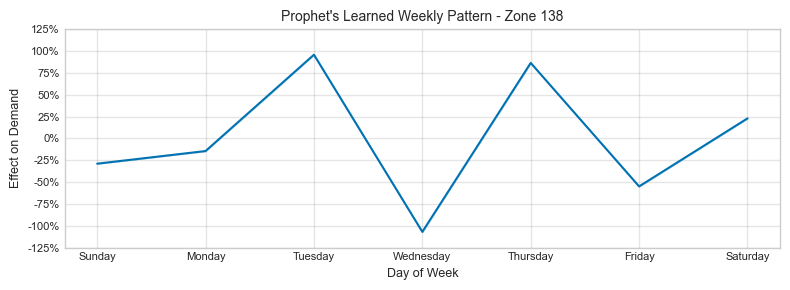

In [37]:
# Examine learned weekly pattern

fig, ax = plt.subplots(figsize=(8, 3))
days = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

# Extract weekly component from Prophet
from prophet.plot import plot_weekly
plot_weekly(model_prophet, ax=ax)
ax.set_title("Prophet's Learned Weekly Pattern - Zone 138")
ax.set_xlabel("Day of Week")
ax.set_ylabel("Effect on Demand")
plt.tight_layout()
plt.show()

**Interpretation:** The Prophet model fit a weekly curve with mid-week peaks and troughs.  This pattern does not align with EDA results showing a simple 17% weekend lift across zones. Since EDA found 76% of zone pairs are correlated, the highest-volume zone (138) should be representative of overall demand patterns. This, along with Prophet's high MAPE(~23%) compared to the baseline's 18.8%, suggests the model added complexity that hurt rather than helped. The stable weekly pattern in this dataset seems to be better captured by simpler lag-based approaches.

### 5.6 Tune Parameters
Prophet underperformed baseline on Zone 138. Tune configurations to determine if tuning can improve performance or if the issue is structural.

In [38]:
# Quick test if Prophet tuning helps

configs = [
    {'name': 'Additive', 'mode': 'additive'},
    {'name': 'Multiplicative', 'mode': 'multiplicative'},
]

print(f"PROPHET TUNING - Zone {PILOT_ZONE_ID}")
print("=" * 40)
print(f"Baseline MAE: {baseline_results['MAE']:,.0f}\n")

for config in configs:
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode=config['mode'],
        changepoint_prior_scale=0.05
    )
    model.add_country_holidays(country_name='US')
    model.fit(prophet_train_df)
    
    forecast = model.predict(prophet_test_df[['ds']])
    mae = mean_absolute_error(prophet_test_df['y'].values, forecast['yhat'].values)
    vs_baseline = (baseline_results['MAE'] - mae) / baseline_results['MAE'] * 100
    
    print(f"{config['name']}: MAE {mae:,.0f} ({vs_baseline:+.1f}% vs baseline)")

11:25:20 - cmdstanpy - INFO - Chain [1] start processing


PROPHET TUNING - Zone 138
Baseline MAE: 2,317



11:25:20 - cmdstanpy - INFO - Chain [1] done processing
11:25:20 - cmdstanpy - INFO - Chain [1] start processing


Additive: MAE 3,043 (-31.3% vs baseline)


11:25:20 - cmdstanpy - INFO - Chain [1] done processing


Multiplicative: MAE 2,474 (-6.8% vs baseline)


**Interpretation:** Given Prophet's poor initial performance, additional tuning was done to confirm it wasn't just a configuration issue. Testing both additive and multiplicative seasonality modes showed consistent underperformance. This suggests the problem is with Prophet's fundamental design, not just these settings.  Prophet Does not appear to be the correct tool for this stable, predictable data. The simple weekly lag captures the dominant pattern more effectively.

---

## 6. Build XGBoost Model
Engineers lag features, trains XGBoost, and analyzes feature importance.

### 6.1 Engineer Features

**Feature Selection Rationale:** Lag-7 was chosen as the primary predictor since EDA revealed stable weekly patterns (same day last week predicts same day this week). Additional features include lag-1 (for short-term trends), rolling_mean_7 (recent week average), and rolling_mean_28 (monthly baseline) to capture different time scales.

In [42]:
# Create lag features for XGBoost (XGBoost needs explicit features for time series modeling 

def create_lag_features(
    df: pd.DataFrame, 
    target_col: str = 'daily_trips', 
    lags: list[int] = [1, 7]
) -> pd.DataFrame:
    """Create lag and rolling features for time series modeling.
    
    Args:
        df: DataFrame with zone_id and target column
        target_col: Name of target variable column
        lags: List of lag periods to create
        
    Returns:
        DataFrame with added lag_N and rolling_mean columns
    """
    df = df.copy()
    for lag in lags:
        df[f'lag_{lag}'] = df.groupby('zone_id')[target_col].shift(lag)
    
    # Rolling features
    df['rolling_mean_7'] = df.groupby('zone_id')[target_col].transform(
        lambda x: x.shift(1).rolling(7, min_periods=1).mean()
    )
    df['rolling_mean_28'] = df.groupby('zone_id')[target_col].transform(
        lambda x: x.shift(1).rolling(28, min_periods=1).mean()
    )
    return df

In [41]:
# Apply to full dataset then re-split
zone_daily_df = create_lag_features(zone_daily_df)

train_xgb_df = zone_daily_df[zone_daily_df['date'] <= TRAIN_END_DATE].copy()
test_xgb_df = zone_daily_df[zone_daily_df['date'] >= TEST_START_DATE].copy()

# Filter to pilot zone
pilot_train_xgb_df = train_xgb_df[train_xgb_df['zone_id'] == PILOT_ZONE_ID].copy()
pilot_test_xgb_df = test_xgb_df[test_xgb_df['zone_id'] == PILOT_ZONE_ID].copy()

print(f"Lag features created: lag_1, lag_7, rolling_mean_7, rolling_mean_28")

Lag features created: lag_1, lag_7, rolling_mean_7, rolling_mean_28


### 6.2 Prepare Data

In [44]:
# Select features for XGBoost model

FEATURE_COLS = [
    # Time features (from EDA)
    'month', 'day_of_week', 'is_holiday',
    # Lag features
    'lag_1', 'lag_7',
    # Rolling features
    'rolling_mean_7', 'rolling_mean_28'
]

TARGET_COL = 'daily_trips'

# Remove rows with NaN from lag creation
pilot_train_xgb_df = pilot_train_xgb_df.dropna(subset=FEATURE_COLS)
pilot_test_xgb_df = pilot_test_xgb_df.dropna(subset=FEATURE_COLS)

X_train = pilot_train_xgb_df[FEATURE_COLS]
y_train = pilot_train_xgb_df[TARGET_COLS]

X_test = pilot_test_xgb_df[FEATURE_COLS]
y_test = pilot_test_xgb_df[TARGET_COLS]

print(f"Features: {len(FEATURE_COLS)}")
print(f"Train samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Features: 7
Train samples: 905
Test samples: 184


### 6.3 Train Model

In [45]:
# Train XGBoost 

model_xgb = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

model_xgb.fit(X_train, y_train)

# Generate predictions
xgb_pred = model_xgb.predict(X_test)

print("XGBoost model trained")

XGBoost model trained


### 6.4 Evaluate XGBoost

In [47]:
# Calculate XGBoost metrics and compare to baseline

xgb_results = evaluate_forecast(
    y_test.values, 
    xgb_pred,
    model_name="XGBoost"
)

# Calculate improvement over baseline
improvement_xgb = (baseline_results['MAE'] - xgb_results['MAE']) / baseline_results['MAE'] * 100

print(f"XGBOOST PERFORMANCE (Zone {PILOT_ZONE_ID} - {pilot_zone_name})")
print("=" * 40)
print(f"Zone mean demand: {zone_mean:,.0f} trips/day")
print(f"MAE:  {xgb_results['MAE']:,.0f} trips/day ({xgb_results['MAE']/zone_mean*100:.1f}% of mean)")
print(f"RMSE: {xgb_results['RMSE']:,.0f} trips/day")
print(f"MAPE: {xgb_results['MAPE']:.1f}%")
print(f"\nvs Baseline: {improvement_xgb:+.1f}%")

XGBOOST PERFORMANCE (Zone 138 - LaGuardia Airport)
Zone mean demand: 11,513 trips/day
MAE:  1,453 trips/day (12.6% of mean)
RMSE: 1,945 trips/day
MAPE: 11.6%

vs Baseline: +37.3%


**Interpretation:** XGBoost achieved 11.6% MAPE on the pilot zone, outperforming both baseline and Prophet. The lag-based features seemed to effectively capture the stable weekly patterns identified in EDA.

### 6.5 Analyze Feature Importance

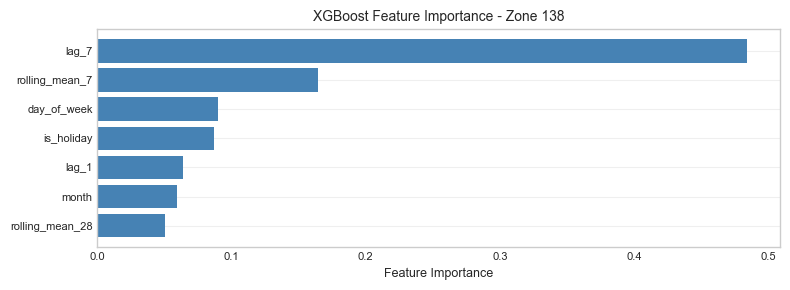

In [48]:
# Display XGBoost feature importance 

importance_df = pd.DataFrame({
    'feature': FEATURE_COLS,
    'importance': model_xgb.feature_importances_
}).sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(8, 3))
ax.barh(importance_df['feature'], importance_df['importance'], color='steelblue')
ax.set_xlabel('Feature Importance')
ax.set_title(f'XGBoost Feature Importance - Zone {PILOT_ZONE_ID}')
plt.tight_layout()
plt.show()

**Interpretation:** Feature importance confirms `lag_7` as the primary predictor. This confirms the EDA finding that weekly patterns drive demand.

---

## 7. Compare Models
Compares model performance and selects best for full-scale forecasting.


### 7.1 Visualize Forecasts

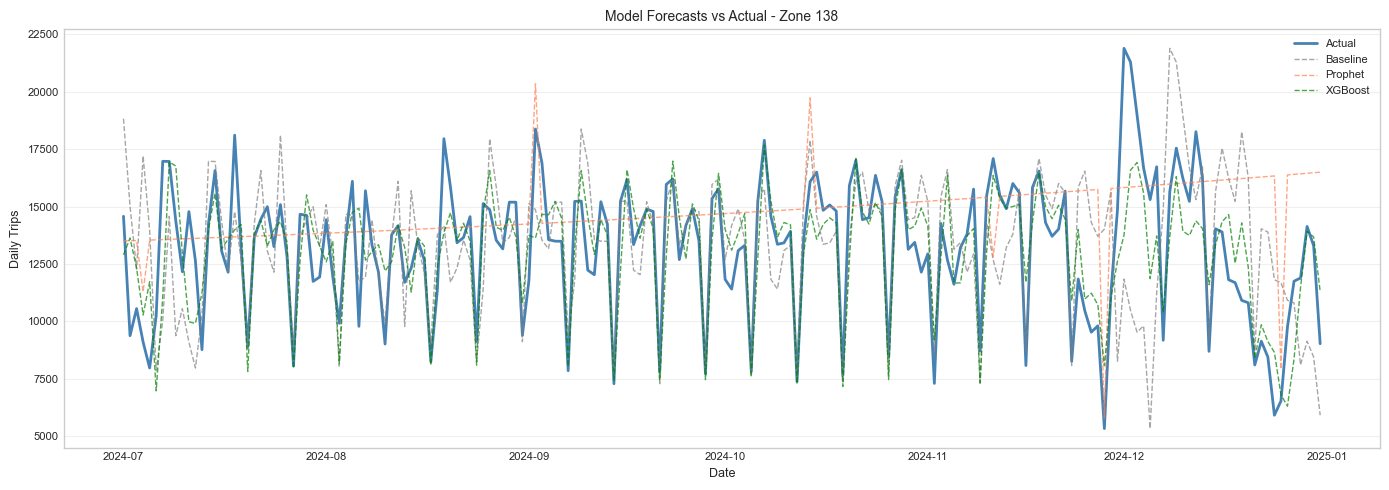

In [49]:
# Plot all forecasts against actual

fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(pilot_test_df['date'], pilot_test_df['daily_trips'], 
        label='Actual', color='steelblue', linewidth=2)
ax.plot(pilot_test_df['date'], pilot_test_df['baseline_pred'], 
        label='Baseline', color='gray', linewidth=1, linestyle='--', alpha=0.7)
ax.plot(pilot_test_df['date'], pilot_test_df['prophet_pred'], 
        label='Prophet', color='coral', linewidth=1, linestyle='--', alpha=0.7)
ax.plot(pilot_test_xgb_df['date'], xgb_pred, 
        label='XGBoost', color='green', linewidth=1, linestyle='--', alpha=0.7)

ax.set_xlabel('Date')
ax.set_ylabel('Daily Trips')
ax.set_title(f'Model Forecasts vs Actual - Zone {PILOT_ZONE_ID}')
ax.legend()
plt.tight_layout()
plt.show()

**Interpretation:** XGBoost (green) tracks actual demand most closely, especially during transitions and the December holiday spike. Prophet (orange) overshoots peaks. The baseline (gray) lags behind as expected. This visual confirms metrics: feature engineering beats both the simple baseline and overly complex Prophet.

### 7.2 Select Best Model

In [51]:
# Compare model performance and select winner

# Build comparison DataFrame from individual results
results_df = pd.DataFrame([baseline_results, prophet_results, xgb_results])

print(f"MODEL COMPARISON - Zone {PILOT_ZONE_ID} ({pilot_zone_name})")
print("=" * 50)
print(results_df.sort_values('MAE').to_string(index=False))

best_model = results_df.loc[results_df['MAE'].idxmin(), 'Model']
best_mae = results_df['MAE'].min()
print(f"\nBest model: {best_model} (MAE: {best_mae:,.0f} trips/day)")

MODEL COMPARISON - Zone 138 (LaGuardia Airport)
                    Model     MAE    RMSE  MAPE
                  XGBoost 1452.53 1944.97 11.59
Baseline (Seasonal Naive) 2316.83 3198.89 18.79
                  Prophet 2474.31 3377.74 23.74

Best model: XGBoost (MAE: 1,453 trips/day)


##### Model Selection Reflection

**Why Prophet underperformed:** Prophet was designed for complex, irregular data with trend changes and messy seasonality (Taylor & Letham, 2018). This dataset's stable weekly patterns and low variability (CV < 0.3) didn't benefit from that flexibility. Prophet's complexity appeared to add noise to a fairly clean signal.

**Why XGBoost succeeded:** Gradient boosting methods like XGBoost are known top performers on stable, high-frequency demand data (Makridakis et al., 2022). Explicit lag features directly captured the consistent weekly structure. The model didn't need to find patterns as they were encoded based on EDA findings.

**Lesson learned:** Data characteristics should guide model selection. This analysis reflected the fact that stable, predictable data favors simpler, feature-driven approaches. More complex models like Prophet may be better suited for datasets with irregular patterns, trend shifts, or varying seasonality across series.

---

## 8. Forecast All Zones with Best Model
Runs best model across all 100 zones and aggregates results.

### 8.1 Build Forecasting Pipeline

In [52]:
# Create reusable function to forecast a single zone with XGBoost - 1 time series

def forecast_zone_xgboost(
    zone_id: int, 
    train_df: pd.DataFrame, 
    test_df: pd.DataFrame, 
    feature_cols: list[str]
) -> pd.DataFrame:
    """Train XGBoost and generate forecasts for a single time-series (zone).
    
    Args:
        zone_id: Zone identifier to forecast
        train_df: Training data with all zones
        test_df: Test data with all zones
        feature_cols: List of feature column names
    
    Returns:
        DataFrame with row-level predictions for analysis and export
    """
    # Filter to zone
    zone_train = train_df[train_df['zone_id'] == zone_id].dropna(subset=feature_cols)
    zone_test = test_df[test_df['zone_id'] == zone_id].dropna(subset=feature_cols)
    
    X_train = zone_train[feature_cols]
    y_train = zone_train['daily_trips']
    X_test = zone_test[feature_cols]
    y_test = zone_test['daily_trips']
    
    # Train
    model = XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    
    # Return detailed results
    return pd.DataFrame({
        'zone_id': zone_id,
        'date': zone_test['date'].values,
        'actual': y_test.values,
        'forecast': model.predict(X_test),
        'day_name': zone_test['day_name'].values,
        'is_weekend': zone_test['is_weekend'].values,
        'is_holiday': zone_test['is_holiday'].values,
        'month': zone_test['month'].values,
        'season': zone_test['season'].values
    })

print("Forecasting pipeline defined")

Forecasting pipeline defined


### 8.2 Run Forecast on All Zones

In [53]:
# Run forecasting pipeline on all  zones

from tqdm import tqdm

zone_ids = zone_daily_df['zone_id'].unique().tolist()
all_forecasts = []

print(f"Forecasting {len(zone_ids)} zones...")

for zone_id in tqdm(zone_ids):
    try:
        zone_forecast = forecast_zone_xgboost(zone_id, train_xgb_df, test_xgb_df, FEATURE_COLS)
        all_forecasts.append(zone_forecast)
    except Exception as e:
        print(f"Zone {zone_id} failed: {e}")

# Combine into single DataFrame
forecast_df = pd.concat(all_forecasts, ignore_index=True)

print(f"\nCompleted: {forecast_df['zone_id'].nunique()} zones")
print(f"Total forecast records: {len(forecast_df):,}")


Forecasting 100 zones...


100%|██████████| 100/100 [00:08<00:00, 11.95it/s]


Completed: 100 zones
Total forecast records: 18,400


### 8.3 Aggregate Forecast Results

In [54]:
# Calculate zone-level metrics from detailed forecasts

zone_results_df = forecast_df.groupby('zone_id').apply(
    lambda x: pd.Series({
        'MAE': mean_absolute_error(x['actual'], x['forecast']),
        'zone_mean': x['actual'].mean(),
        'MAPE': (np.abs(x['actual'] - x['forecast']) / x['actual']).mean() * 100
    })
).reset_index()

zone_results_df['MAPE'] = zone_results_df['MAPE'].round(1)

# Overall performance
overall_mean_demand = zone_results_df['zone_mean'].mean()
overall_mae = zone_results_df['MAE'].mean()
overall_mape = zone_results_df['MAPE'].mean()

print("XGBOOST PERFORMANCE (All Zones)")
print("=" * 40)
print(f"Overall mean demand: {overall_mean_demand:,.0f} trips/day")
print(f"MAE:  {overall_mae:,.0f} trips/day ({overall_mae/overall_mean_demand*100:.1f}% of mean)")
print(f"MAPE: {overall_mape:.1f}%")

XGBOOST PERFORMANCE (All Zones)
Overall mean demand: 4,621 trips/day
MAE:  301 trips/day (6.5% of mean)
MAPE: 6.4%


**Interpretation:**
- **6.5% MAPE** across 100 zones shows strong performance, well within the <10% production threshold
- **Lag features appropriate for modeling this data** — weekly demand patterns identified in EDA are captured across the full dataset

### 8.4 Verify No Unaddressed Seasonality

In [55]:
# Calculate residuals
forecast_df['residual'] = forecast_df['actual'] - forecast_df['forecast']

# Check for seasonal bias by month
print("RESIDUAL ANALYSIS")
print("=" * 50)
print("\nMean Residual by Month:")
monthly_residuals = forecast_df.groupby('month')['residual'].mean().round(0)
print(monthly_residuals.to_string())

print("\nMean Residual by Day of Week:")
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_residuals = forecast_df.groupby('day_name')['residual'].mean().round(0)
dow_residuals = dow_residuals.reindex(dow_order)
print(dow_residuals.to_string())

RESIDUAL ANALYSIS

Mean Residual by Month:
month
7    -23.0
8    -60.0
9    -19.0
10   -27.0
11     7.0
12    74.0

Mean Residual by Day of Week:
day_name
Monday       -8.0
Tuesday      26.0
Wednesday   -37.0
Thursday     -9.0
Friday       26.0
Saturday     33.0
Sunday      -88.0


**Interpretation:** Mean residuals are small relative to demand (~1-2% of daily mean). December shows slight under-prediction (+74 trips) and Sunday slight over-prediction (-88 trips), but not enough bias that would require STL decomposition.

---

## 9. Evaluate Overall Performance
Analyze error distribution across zones, visualize performance patterns, and identify problem zones.

### 9.1 Visualize Performance Distribution

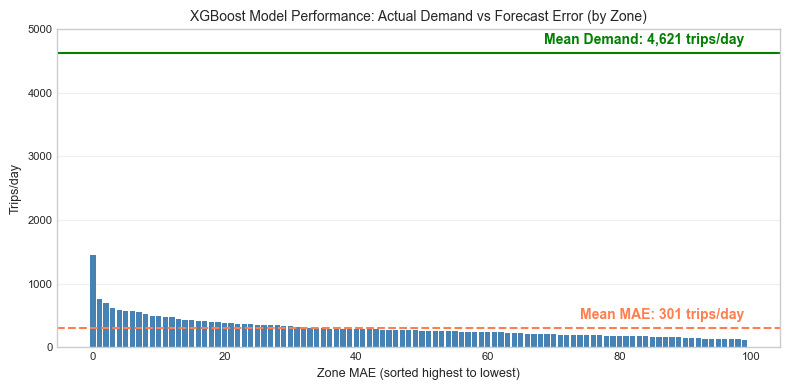

In [58]:
# Visualize MAE distribution across zones with demand 

fig, ax = plt.subplots(figsize=(8, 4))

sorted_results_df = zone_results_df.sort_values('MAE', ascending=False)
ax.bar(range(len(sorted_results_df)), sorted_results_df['MAE'], color='steelblue')

# Mean demand line with label
ax.axhline(overall_mean_demand, color='green', linestyle='-')
ax.text(len(sorted_results_df) - 1, overall_mean_demand + 100, 
        f"Mean Demand: {overall_mean_demand:,.0f} trips/day", 
        ha='right', va='bottom', color='green', fontweight='bold')

# Mean MAE line with label
ax.axhline(zone_results_df['MAE'].mean(), color='coral', linestyle='--')
ax.text(len(sorted_results_df) - 1, zone_results_df['MAE'].mean() + 100, 
        f"Mean MAE: {zone_results_df['MAE'].mean():,.0f} trips/day", 
        ha='right', va='bottom', color='coral', fontweight='bold')

ax.set_xlabel('Zone MAE (sorted highest to lowest)')
ax.set_ylabel('Trips/day')
ax.set_ylim(0, 5000)
ax.set_title('XGBoost Model Performance: Actual Demand vs Forecast Error (by Zone)')

plt.tight_layout()
plt.show()

**Interpretation:** The chart shows XGBoost achieves strong performance across all 100 zones:
- **Mean forecast error:** 301 trips/day (6.5% of mean demand)
- **High-volume zones** show larger absolute errors but remain well below demand baseline
- **Model generalizes well** — the gap between actual demand and forecast error stays consistent across zones

In [59]:
# Validate forecast quality
assert overall_mape < 15, f"MAPE {overall_mape:.1f}% exceeds acceptable threshold"
assert zone_results_df['MAE'].min() > 0, "Invalid MAE values"
assert zone_results_df['zone_id'].nunique() == 100, "Missing zones in results"

### 9.2 Identify Problem Zones

In [60]:
# Find zones with highest forecast error that may need different approach

print("TOP 10 WORST PERFORMING ZONES")
print("=" * 40)
worst_zones_df = zone_results_df.nlargest(10, 'MAE')
display(worst_zones_df)

print("\nTOP 10 BEST PERFORMING ZONES")
print("=" * 40)
best_zones_df = zone_results_df.nsmallest(10, 'MAE')
display(best_zones_df)

TOP 10 WORST PERFORMING ZONES


,zone_id,MAE,zone_mean,MAPE
47,138,1452.526001,13219.652174,11.6
45,132,750.672241,11599.766304,6.6
57,161,689.195618,7487.625000,10.2
27,79,614.766479,8338.668478,7.8
80,230,584.400146,7910.358696,8.9
28,80,575.745850,5206.135870,10.8
92,246,571.234863,6769.413043,8.8
96,255,549.902832,6538.043478,8.2
39,112,529.459656,6250.336957,8.6
10,37,492.027466,6923.875000,6.7



TOP 10 BEST PERFORMING ZONES


,zone_id,MAE,zone_mean,MAPE
65,174,118.205994,2672.331522,4.4
63,169,125.356903,2952.032609,4.1
22,72,131.923935,3235.722826,3.9
85,235,132.194382,2676.201087,4.7
73,213,134.382629,3015.728261,4.4
33,91,134.528214,3158.146739,4.2
26,78,135.453522,2757.967391,4.9
21,71,139.817749,2817.059783,4.8
95,254,140.854172,3081.951087,4.4
20,69,148.365997,3168.836957,4.7


**Interpretation:**
- **Worst performers are high-volume zones** — Zone 138 (13,220 trips/day) has highest MAE (1,453) but MAPE remains acceptable at 11.6%
- **Best performers are lower-volume zones** — averaging 2,500-3,000 trips/day with MAPE as low as 3.9%
- **No zone exceeds 15% MAPE** — model performs within acceptable range across all 100 zones

---

## 10. Export Results
Export forecast and summary files for dashboard and reporting.

### 10.1 Add Derived Columns for Dashboard

In [ ]:
# Calculate error metrics and context columns for Tableau export

# Error calculations
forecast_df['error'] = forecast_df['forecast'] - forecast_df['actual']
forecast_df['abs_error'] = forecast_df['error'].abs()
forecast_df['pct_error'] = (forecast_df['abs_error'] / forecast_df['actual'] * 100).round(2)

# Zone context
forecast_df = forecast_df.merge(
    zone_results_df[['zone_id', 'zone_mean']], 
    on='zone_id', 
    how='left'
)

# Week-over-week change
forecast_df = forecast_df.sort_values(['zone_id', 'date'])
forecast_df['forecast_wow_change'] = (
    forecast_df.groupby('zone_id')['forecast']
    .pct_change(7) * 100
).round(1)

# Forecast vs zone baseline
forecast_df['vs_zone_mean_pct'] = (
    (forecast_df['forecast'] - forecast_df['zone_mean']) / forecast_df['zone_mean'] * 100
).round(1)

print("Derived columns added")

Derived columns added


### 10.2 Add Zone Metadata

In [61]:
zone_metadata_df.head()

,zone_id,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [62]:
# Add zone names and borough for geographic filtering

forecast_df = forecast_df.merge(
   zone_metadata_df[['zone_id', 'Zone', 'Borough']], 
     on='zone_id', 
     how='left'
 )
# Rename fields for consistency 
forecast_df = forecast_df.rename(columns={'Zone': 'zone_name', 'Borough': 'borough'})
forecast_df.head()

,zone_id,date,actual,forecast,day_name,is_weekend,is_holiday,month,season,residual,zone_name,borough
0,7,2024-07-01,5178,5281.307617,Monday,False,False,7,summer,-103.307617,Astoria,Queens
1,7,2024-07-02,5157,5029.991211,Tuesday,False,False,7,summer,127.008789,Astoria,Queens
2,7,2024-07-03,6009,5458.342773,Wednesday,False,False,7,summer,550.657227,Astoria,Queens
3,7,2024-07-04,6333,6066.226074,Thursday,False,True,7,summer,266.773926,Astoria,Queens
4,7,2024-07-05,6353,6619.083496,Friday,False,False,7,summer,-266.083496,Astoria,Queens


### 10.3 Export Forecast Results

In [64]:
# Save production-ready forecast dataset

# Column selection and ordering
export_columns = [
    # Identifiers
    'zone_id', 'zone_name', 'borough', 'date',
    # Core metrics
    'actual', 'forecast', 'error', 'abs_error', 'pct_error',
    # Context
    'zone_mean', 'vs_zone_mean_pct', 'forecast_wow_change',
    # Time dimensions
    'day_name', 'is_weekend', 'is_holiday', 'month', 'season'
]

export_cols = [c for c in export_columns if c in forecast_df.columns]
forecast_results_df = forecast_df[export_cols].copy()

# Save
forecast_results_df.to_csv(RESULTS_DIR / "forecast_results.csv", index=False)

print("\nFORECAST RESULTS EXPORT")
print("=" * 40)
print(f"File: forecast_results.csv")
print(f"Zones: {forecast_results_df['zone_id'].nunique()}")
print(f"Date range: {forecast_results_df['date'].min()} to {forecast_results_df['date'].max()}")
print(f"Records: {len(forecast_results_df):,}")


FORECAST RESULTS EXPORT
File: forecast_results.csv
Zones: 100
Date range: 2024-07-01 00:00:00 to 2024-12-31 00:00:00
Records: 18,400


### 10.4 Export Summary Results

In [66]:
# Export zone-level metrics in separate file

zone_results_df.to_csv(RESULTS_DIR / "summary_results.csv", index=False)

print("\nSUMMARY RESULTS EXPORT")
print("=" * 40)
print(f"File: summary_results.csv")
print(f"Zones: {zone_results_df['zone_id'].nunique()}")
print(f"Metrics: MAE, MAPE, zone_mean")
print(f"Records: {len(zone_results_df):,}")


SUMMARY RESULTS EXPORT
File: summary_results.csv
Zones: 100
Metrics: MAE, MAPE, zone_mean
Records: 100


## Conclusion

XGBoost achieved 6.4% MAPE across all zones, exceeding the operational planning target of <10% MAPE for next-day forecasting. During pilot zone testing (LaGuardia Airport), XGBoost achieved 11.6% MAPE, significantly outperforming Prophet (23.7%) and the seasonal baseline (18.8%). This result aligns with industry research showing gradient boosting methods perform well on stable, high-frequency demand data.

This result alligns with EDA which showed stable weekly patterns, low within-zone variability and high correlation across zones. These characteristics favor tree-based models and explained XGBoost's superior performance over Prophet's more complex seasonal decomposition approach.

**Limitations:** While the model performance was good, this analysis demonstrates 1-day-ahead forecasting. For operational 7-day planning, XGBoost would require recursive forecasting where predictions become inputs for subsequent days. Prophet naturally handles multi-day forecasts without this additional complexity.

### Future Work

- Extend forcasting across 1-7 day horizons using recursive/horizon forecasting
- Compare XGBoost vs Prophet performance at different forecast horizons
- Expand analysis from top 100 zones to all zones


## References

- Hyndman, R.J., & Athanasopoulos, G. (2021). *Forecasting: Principles and Practice* (3rd ed.). https://otexts.com/fpp3/
- Makridakis, S., Spiliotis, E., & Assimakopoulos, V. (2022). M5 accuracy competition: Results, findings, and conclusions. *International Journal of Forecasting*, 38(4), 1346-1364.
- Taylor, S.J., & Letham, B. (2018). Forecasting at Scale. *The American Statistician*, 72(1), 37-45.
```